In [1]:
import random
import operator
import powerlaw
import numpy as np
import collections
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.cm as cm
from pylab import rcParams
from itertools import count
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import pyplot, patches 
from numpy.random import default_rng
from community import community_louvain
from timeit import default_timer as timer
from collections import defaultdict, Counter
from scipy.sparse.csgraph import floyd_warshall, dijkstra

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Analyze a Network

### (1.a) Load the Network.

In [3]:
Gx = nx.read_edgelist('infect-dublin.edges', nodetype = int )

In [4]:
print(f'No of Nodes in the network {len(Gx.nodes)}')
print(f'No of Edges in the network {len(Gx.edges)}')

No of Nodes in the network 410
No of Edges in the network 2765


### (1.b) Plot the Network Adjacency Matrix.

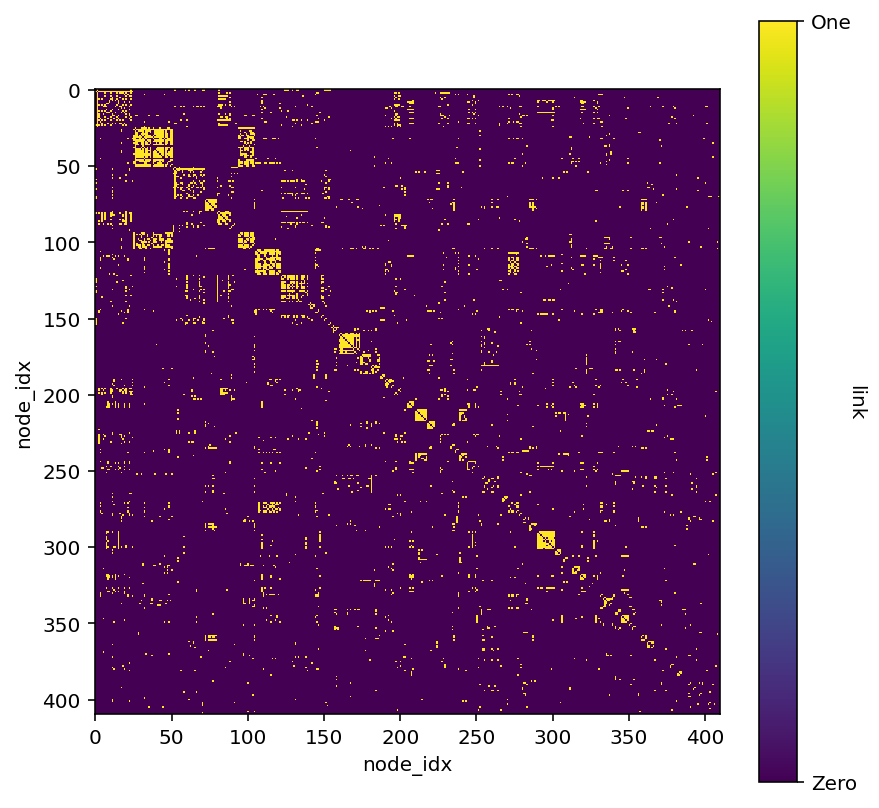

In [5]:
# Plot for the adjacency matrix
G_adj = nx.adjacency_matrix(Gx)
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
plt.imshow(nx.to_numpy_matrix(Gx), interpolation='nearest', )

cbar = plt.colorbar(ticks = [0,1])
cbar.ax.set_yticklabels(['Zero','One'])

cbar.set_label(label = 'link', rotation = 270)
plt.xlabel('node_idx')
plt.ylabel('node_idx')
plt.show()

### (1.c) Plot the Degree distribution.

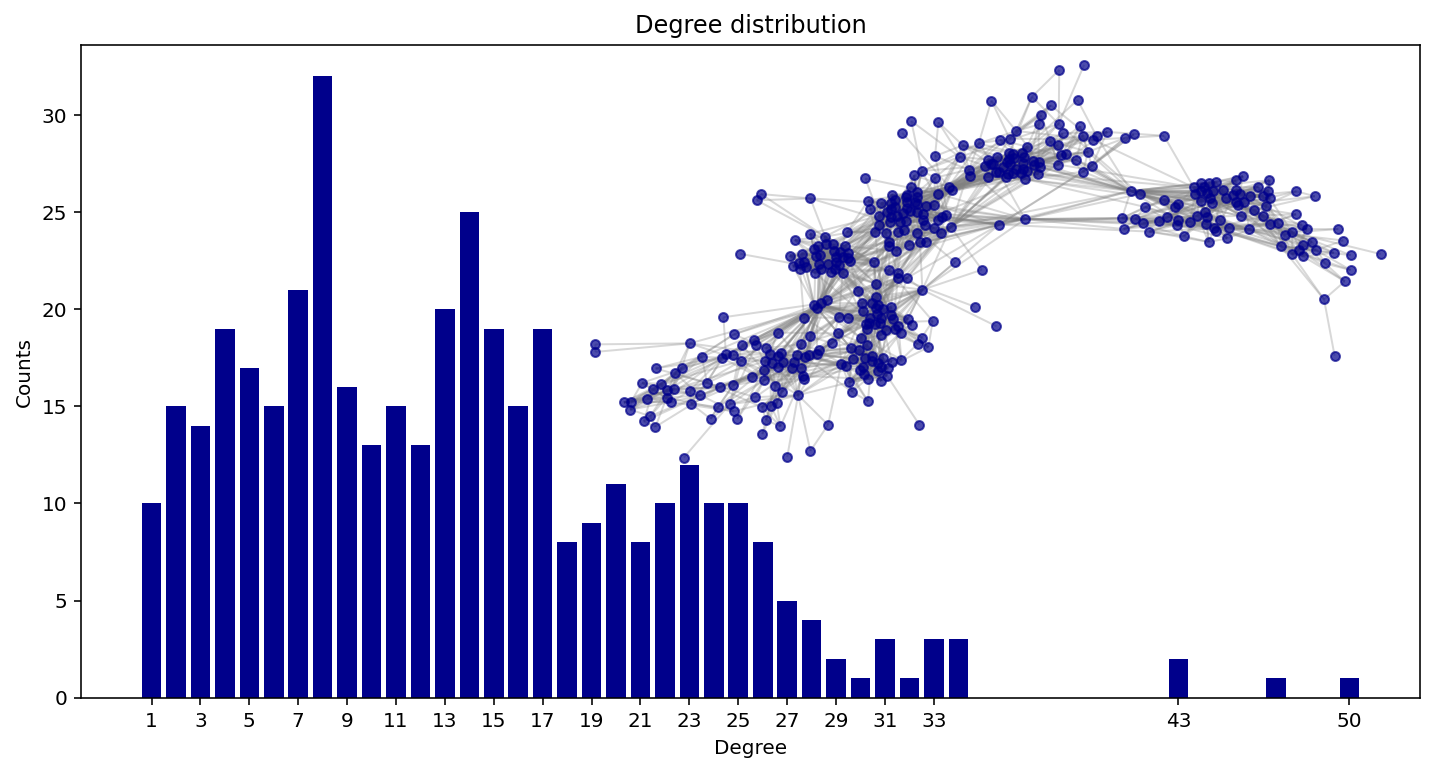

In [6]:
degree = sorted([deg for node, deg in Gx.degree()])
deg, cnt = zip(*collections.Counter(degree).items())
fig, ax = plt.subplots()
fig.set_size_inches(12, 6, forward=True)
plt.title("Degree distribution")
plt.ylabel("Counts")
plt.xlabel("Degree")
plt.bar(deg, cnt, width = 0.8, color='darkblue')
ax.set_xticks(deg) # sets the location of labels
ax.set_xticklabels(deg) # sets the label text
ax.set_xticks(ax.get_xticks()[::2])
plt.axes([0.4, 0.38, 0.5, 0.5]) # Setting the axes
pos = nx.spring_layout(Gx)

nx.draw_networkx_nodes(Gx, pos, node_color= 'darkblue', node_size=20, alpha=0.7) # Plot the nodes
nx.draw_networkx_edges(Gx, pos, edge_color = 'gray', alpha = 0.3) # Plot the edges

plt.axis('off')
plt.show()

### (1.d) Plot the Degree sequence. 
#### Using the powerlaw package on python, plot the degree sequence and check if has a powerlaw distribution

Calculating best minimal value for power law fit


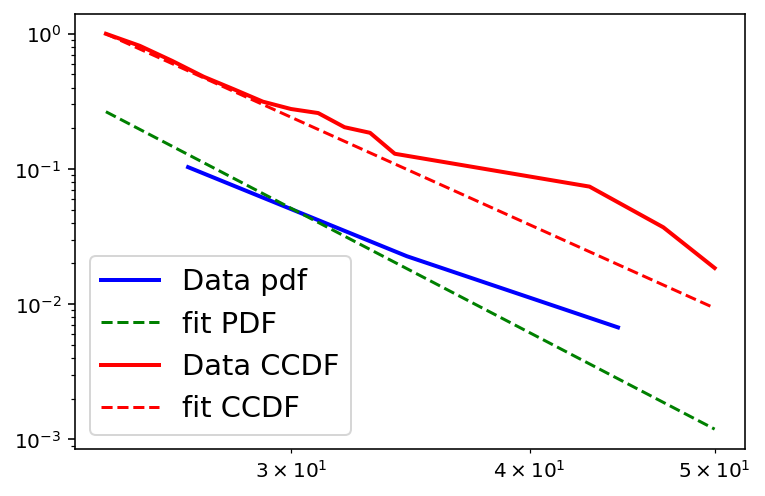

In [7]:
degree_sequence = sorted([d for n, d in Gx.degree()], reverse=True) # used for degree distribution and powerlaw test
fit = powerlaw.Fit(degree_sequence) 
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
fit.power_law.plot_ccdf(color='r', linestyle='dashed', ax=fig2)
plt.legend(['Data pdf', 'fit PDF', 'Data CCDF', 'fit CCDF'], fontsize = 'x-large')
plt.show()

### (1.e) Is the Network you are analyzing Assortative or Disassortative?

<b>Assortativity:</b>
- It can be defined as the tendency for nodes with similar properties to connect with each other in a network.  
- In such networks, adjacent nodes tend to be similar.

<b>Disassortativity:</b>
- It can be defined as the tendency for nodes with dissimilar properties to connect with each other in a network. 
- In such networks, adjacent nodes tend to be dissimilar.

The assortativity coefﬁcient is a Pearson correlation coefﬁcient of some node property  f  between pairs of connected nodes. Positive coefﬁcients imply assortativity, while negative ones imply disassortativity.

In [8]:
assortativity = nx.degree_assortativity_coefficient(Gx)
print('Degree Assortativity Coeff. of the network is ', round(assortativity,8))

Degree Assortativity Coeff. of the network is  0.22575195


Text(0.5, 1.0, 'Degree-Degree scatter plot')

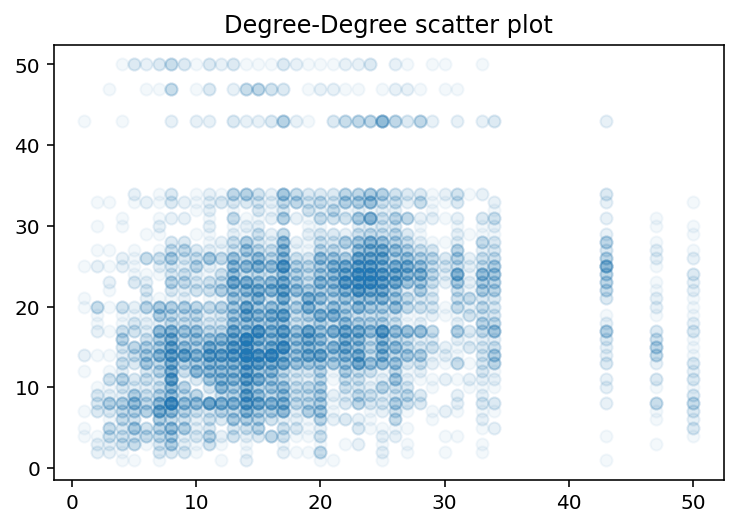

In [9]:
x_data = []
y_data = []
for i,j in Gx.edges():
    x_data.extend([Gx.degree(i), Gx.degree(j)])
    y_data.extend([Gx.degree(j), Gx.degree(i)])   
plt.scatter(x_data, y_data, alpha=0.05)
plt.title('Degree-Degree scatter plot')

- From the degree-degree scatter plot for the given network, for each edge, the degrees of its two ends are stored in x_data and y_data twice in different orders, because an undirected edge should be counted in two directions.

- In the graph, each dot represents one directed edge in the network (so, an undirected edge is represented by two dots symmetrically placed across a diagonal mirror line). 

- It can be seen that most edges connect low-degree nodes to each other, with some edges connecting low-degree and high-degree nodes, but it is quite rare that high-degree nodes are connected to each other. 
<br><b>Therefore, there is a mild positive degree correlation in this case.</b>

Ref: Chapter 17, Introduction to the Modeling and Analysis of Complex Systems Sayama

# 2. Centrality and Community Detection

### (2.a) Centralities
#### Explain the degree centrality, and the eigenvector centrality. What are the differences between the two? Provide one practical example for the degree centrality and one for the eigenvector centrality. When is useful to apply  each of two metrics. Motivate your answers.

<b> Degree Centrality:</b> 
The most simple measure of centrality and the earliest in history is degree centrality. 
- Degree centrality (CD) is considered to be the number of edges connected to a node. In case of directed networks, two separate measures of degree centrality are defined - indegree and outdegree. While the no of incoming edges is called the in-degree, no of outgoing edges is called the outdegree. 

- Degree Centrality can be defined using the following equation:
$$C_D(i)=\sum_{j=1; j \neq i}^N A_{ij}$$
where $N$ is the total number of nodes and $A_{ij}$ is an element of the binary adjacency matrix, either 1 or 0 if the node $j$ is connected or not to the node $i$.

- In a social network, degree centrality is often used as a measure of popularity, especially in directed networks
- It is also used to answer questions like:
    - Who is the most / least popular node in this network?
    - Who can call upon the most resources in this network?
- This does not capture cascade effects : 'A node is more important if it's neighbors are also important'
<br>

<b>Eigenvector centrality:</b> 
Eigen Centrality is a natural extension of degree centrality is eigenvector centrality. 
- EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network by going a step further and taking into account how well connected a node is, and how many links their connections have, and so on through the network. It's useful because it indicates direct infuence and influence over nodes more than one ‘hop’ away.

- A node may have a high degree score (i.e. many connections) but a relatively low EigenCentrality score if many of those connections are with similarly low-scored nodes, and vice versa. 

- It answers questions like:
    - Who or what holds wide-reaching influence in my network?
    - Who or what is important in my network on a macro scale?
<br>
- <b> Practical Example: </b>One sample application of eigen centrality is the calculation of Page Rank or Page Rank algorithm used by Google, which is an extension of this.
<br>

<b>Difference between Degree and Eigenvector centrality: </b>
- Degree centrality awards one centrality point for every link to the node. But in eigenvector centrality, a node is important if it is linked to another important node. 
- Degree centrality gives the number of relationship degrees connected to the node whereas the eigenvector gives the influential node in the network. 
- In Eigenvector centrality, a node receiving many links does not necessarily have a high eigenvector centrality and a node with high eigenvector centrality is not necessarily highly linked which is the opposite way of degree centrality.


- <b> When to use Degree Centrality</b>: For finding very connected individuals, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network.

- <b>When to use EigenCentrality:</b> EigenCentrality is good for understanding human social networks, for understanding networks like malware propagation. This also can be used to find Influential persons in the country, 



### (2.b.i) Closeness Centrality.
#### Code the function centrality_closeness(),that inputs the network and returns the closeness centrality of each nodes.

In [10]:
def centrality_closeness(R):
    nodes_list = list(R.nodes)
    adj_mat = nx.adjacency_matrix(R).tolil()
    dist = dijkstra(adj_mat, directed = False) # Calculating dijkstra's shortest path amongst all nodes 
    no_of_nodes = adj_mat.shape[0]
    closeness_centrality = {}
    # Calculating the closeness Centrality
    for node in range(dist.shape[0]):
        shortest_path = dist[node][:]
        total_nodes = len(shortest_path)
        sp_sum = shortest_path.sum()
        closeness_centrality[nodes_list[node]] = np.divide(total_nodes - 1, sp_sum)
    return closeness_centrality

In [11]:
R = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
my_cc = centrality_closeness(R)
nx_cc = nx.closeness_centrality(R)
if my_cc == nx_cc:
    print(' Custom Closeness Centrality Implementation gave same results as Networkx Implementation')

 Custom Closeness Centrality Implementation gave same results as Networkx Implementation


### (2.b.ii) Closeness Centrality
#### Using Gx, compare the result of your metrics centrality_closeness() with the betweenness centrality, with a scatter plot on the x closeness centrality measure and y the betweenness centrality one. Is there any correlation? Why? explain your answer.

The correlation between is betweenness centrality and closeness centrality is 0.43


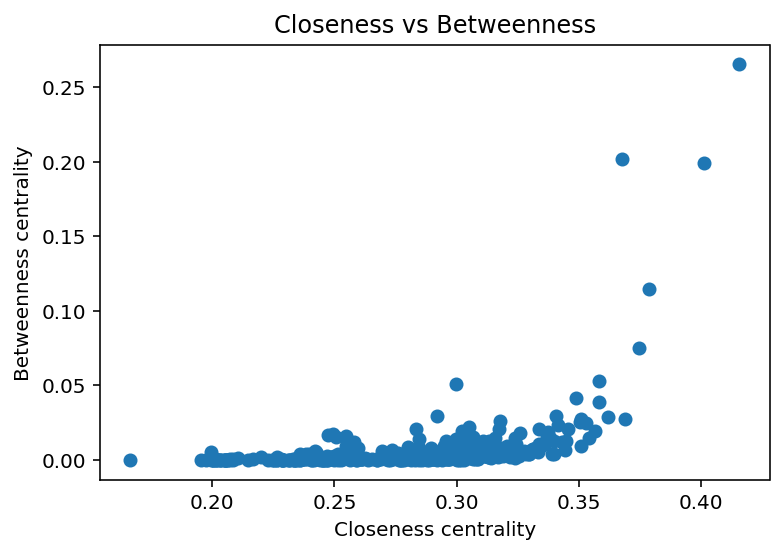

In [12]:
from scipy.stats import pearsonr

bet_cen = nx.betweenness_centrality(R) # Calculating betweenness centrality

corr, _ = pearsonr(list(my_cc.values()), list(bet_cen.values())) # Getting Pearson Coefficient

print(f'The correlation between is betweenness centrality and closeness centrality is {round(corr,2)}')

# Plot the graph with closeness vs betweenness centrality values
plt.title('Closeness vs Betweenness')
plt.scatter(my_cc.values(),bet_cen.values())
plt.xlabel('Closeness centrality')
plt.ylabel('Betweenness centrality')
plt.show()

- From the above we can see that the correlation between betweenness centrality and closeness centrality is positive but not strong enough.
- We can see that level of correlation seems nearly optimal - too high a correlation would indicate redundancy and too low a correlation would indicate that the variables measured different things.
- The amount of correlation between closeness and betweenness indicates that these measures are distinct, yet conceptually related.

### **(2.c) Centrality Measure.**
#### Please consider now the network Gx loaded in question 1.a.. Imagine that Gx is now representing a social network, similar to Facebook, Instagram or WeChat. You have to advertise a product and you have budget to hire only one influencer (i.e. a node in the network Gx). Using the metrics within the centrality metrics we saw during the lectures ECMM466 and the Labs, suggest the influencer you will hire (as Node id). Motivate your decision. Finally plot the network having the nodes color coded with their centrality measure and with the node selected as influence colored in dark green.

#### **Working Assumptions:**
First, let us make some working assumptions on the social media platform:

Each user can <b>ENGAGE</b> with the content by liking it, commenting on it, or sharing it.

1.   Based on the coursework, the social media platform is **UNDIRECTED**, meaning it is a **BI-DIRECTED network**.
2.   The content published by the influencer can be viewed by users who are adjacent to the influencer.
3.   Based on <b>ENGAGEMENT</b>, the Social Media Platform (similar to Facebook, Instagram, or WeChat) spreads the content further using various recommendation systems and other similar algorithms, alteast to immediate neighbors
4.  All these neighboring nodes will also have the ability to ENGAGE with it further and increase the spread thereby.


#### **Choosing a Centrality Measure:**
In this setting, a few <b>relevant</b> centrality metrics that can be considered are Degree Centrality, Eigen Centrality, Katz and Page Rank Centrality.


1.   **Degree centrality:** A node is important if it is highly linked. This is simply the number of edges of the edge.
2.   **Eigenvalue centrality:** EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.
3. **Katz centrality:** A node is important if it is highly linked or if it is linked from other important nodes.
4. **PageRank:** A node is important if it is highly linked or if it is linked from other important nodes that do not link many other pages.

- For our purposes, a node with high degree centrality might not always work because high degree only indicates that there're many nodes reachable with in radius = 1 distance. It doesn't give us any information about radius = 2 and beyond. 
- As I'm treating this network as bi-directed, I can choose to ignore Eigenvalue centrality because Katz and PageRank are extensions of EigenValue centrality which try to overcome the limitations of it.  
- A potential problem with Katz centrality is the following: if a node with high centrality links many others, then all the other nodes get high centrality. The centrality gained by virtue of receiving a link from an important node should be diluted if the important vertex is very magnanimous with endorsements. PageRank is an adjustment of Katz centrality that takes into consideration this issue[1].
- "Katz is not as adequate for the task of important actors detection since it fails to detect what we refer to as indirect gloating, the situation where an actor capitalizes on other actors referring to him"[2] </br>

#### Hence, I would like to choose Page Ranking as the best centrality metric in this scenario to choose the best influencer.
PageRank uncovers influential or important nodes whose reach extends beyond just their direct connections. It identifies the significance of nodes by assigning a score based on the number of incoming links (its ‘indegree’). PageRank is another way of answering similar questions to EigenCentrality, i.e.:
- Who or what holds wide-reaching influence in my network?
- Who or what is important in my network on a macro scale?

1. <i>https://www.sci.unich.it/~francesc/teaching/network/pagerank</i>
2. <i>"Page Rank Versus Katz: Is the Centrality Algorithm Choice Relevant to Measure User Influence in Twitter? Rosa H., Carvalho J.P., Astudillo R., Batista F. (2018)" </i>


#### Let us test various centrality measures to see if our choice is correct. 
<i> Not just because we have the computational capability, but also because in real time scenario, we would always want to be doubly sure of the influencer that we're hiring that he's the right person because of the budget contraint.</i>

In [13]:
Gx = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
# Let us get the most central node and it's centrality value based on the above discussed measures

# Getting Influencer based on Degree Centrality
deg_dict = nx.degree_centrality(Gx)
deg_influencer = max(deg_dict.items(), key=operator.itemgetter(1))
deg_node = deg_influencer[0]
deg_value = round(deg_influencer[1],8)

# Getting Influencer based on Eigen Centrality
eig_dict = nx.eigenvector_centrality(Gx)
eig_influencer = max(eig_dict.items(), key=operator.itemgetter(1))
eig_node = eig_influencer[0]
eig_value = round(eig_influencer[1],8)

# Getting Influencer based on PageRank Centrality
pag_dict = nx.pagerank_scipy(Gx)
pag_influencer = max(pag_dict.items(), key=operator.itemgetter(1))
pag_node = pag_influencer[0]
pag_value = round(pag_influencer[1],8)

# Getting Influencer based on Katz Centrality
kat_dict = nx.katz_centrality_numpy(Gx)
kat_influencer = max(kat_dict.items(), key=operator.itemgetter(1))
kat_node = kat_influencer[0]
kat_value = round(kat_influencer[1],8)

# Calculating Influence of the influencer nodes by calculating the no. of nodes in the ego graph at various radius levels 
deg_influence_1 = len(nx.ego_graph(Gx, n = deg_influencer[0], radius = 1).nodes)
deg_influence_2 = len(nx.ego_graph(Gx, n = deg_influencer[0], radius = 2).nodes)
deg_influence_3 = len(nx.ego_graph(Gx, n = deg_influencer[0], radius = 3).nodes)
eig_influence_1 = len(nx.ego_graph(Gx, n = eig_influencer[0], radius = 1).nodes)
eig_influence_2 = len(nx.ego_graph(Gx, n = eig_influencer[0], radius = 2).nodes)
eig_influence_3 = len(nx.ego_graph(Gx, n = eig_influencer[0], radius = 3).nodes)
pag_influence_1 = len(nx.ego_graph(Gx, n = pag_influencer[0], radius = 1).nodes)
pag_influence_2 = len(nx.ego_graph(Gx, n = pag_influencer[0], radius = 2).nodes)
pag_influence_3 = len(nx.ego_graph(Gx, n = pag_influencer[0], radius = 3).nodes)
kat_influence_1 = len(nx.ego_graph(Gx, n = kat_influencer[0], radius = 1).nodes)
kat_influence_2 = len(nx.ego_graph(Gx, n = kat_influencer[0], radius = 2).nodes)
kat_influence_3 = len(nx.ego_graph(Gx, n = kat_influencer[0], radius = 3).nodes)

In [14]:
# Let us print the central nodes based on the above discussed metrics
from tabulate import tabulate
print(tabulate([
                ['Degree', deg_node, deg_value, deg_influence_1, deg_influence_2, deg_influence_3],
                ['Eigen',eig_node, eig_value, eig_influence_1, eig_influence_2, eig_influence_3],
                ['PageRank', pag_node, pag_value, pag_influence_1, pag_influence_2, pag_influence_3],
                ['Katz', kat_node, kat_value, kat_influence_1, kat_influence_2, kat_influence_3]], 
                headers=['Centrality','Central Node', 'Centrality Value', 'Influence(r = 1)',' Influence(r = 2)', ' Influence(r = 3)'],tablefmt="grid", disable_numparse=True)
     )

+--------------+----------------+--------------------+--------------------+---------------------+---------------------+
| Centrality   | Central Node   | Centrality Value   | Influence(r = 1)   |  Influence(r = 2)   |  Influence(r = 3)   |
+==============+================+====================+====================+=====================+=====================+
| Degree       | 157            | 0.12224939         | 51                 | 232                 | 351                 |
+--------------+----------------+--------------------+--------------------+---------------------+---------------------+
| Eigen        | 286            | 0.20698222         | 34                 | 107                 | 227                 |
+--------------+----------------+--------------------+--------------------+---------------------+---------------------+
| PageRank     | 157            | 0.00879944         | 51                 | 232                 | 351                 |
+--------------+----------------+-------

#### From the above, we can see from the above that both the Page Rank Centrality and Degree Centrality define node <i>157</i> as the influencial node. Hence, in this case, choosing 157 makes all the more sense because assuming that information spread stops at radius 1, using 157 node provides us with the maximum coverage.
Now that we've chosen our influencer node, let us plot the network having the nodes color coded with their centrality measure and with the node selected as influence colored in dark green.

In [44]:
def draw(G, pos, measure, measure_name, color):
    """
    This function draws a network based on a specific metric in the color and a specified layout

    Parameters
    ----------
    G : graph
      A NetworkX graph

    pos : dictionary, 
      A dictionary with nodes as keys and positions as values.

    measure : dictionary
      Results of the centrality measure

    measure_name: str
       Name of the centrality measure used 
    """

    # Get the influencer node from measure
    influencer_node_index = max(enumerate(measure.values()), key = operator.itemgetter(1))[0]
    influencer_node  = list(measure.keys())[influencer_node_index]

    # Plot the graph
    plt.figure(figsize=(20, 15))
    # Draw the nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size = 100, cmap = color,
                                   node_color = list(measure.values()), nodelist = list(measure.keys())) 
    # Draw Influencer Node with size = 800
    nx.draw_networkx_nodes(G, pos, node_size = 800, node_color = 'darkGreen', nodelist= [influencer_node]) 
    
    # Draw the edges
    edges = nx.draw_networkx_edges(G, pos, edge_color = 'gray', alpha = 0.3)
    # Draw label only for the influencer node
    nx.draw_networkx_labels(G, pos, font_size = 15, labels = {influencer_node: str(influencer_node)},font_color = 'w')
    plt.title(measure_name, size=30, weight='bold')
    # Setting the Colorbar
    cbar = plt.colorbar(nodes,  label = measure_name)
    cbar.set_label(label = measure_name, size = 30 ,weight='bold', rotation=270, labelpad = 35)
    cbar.ax.tick_params(labelsize= 15)  
    plt.axis('off')
    plt.show()

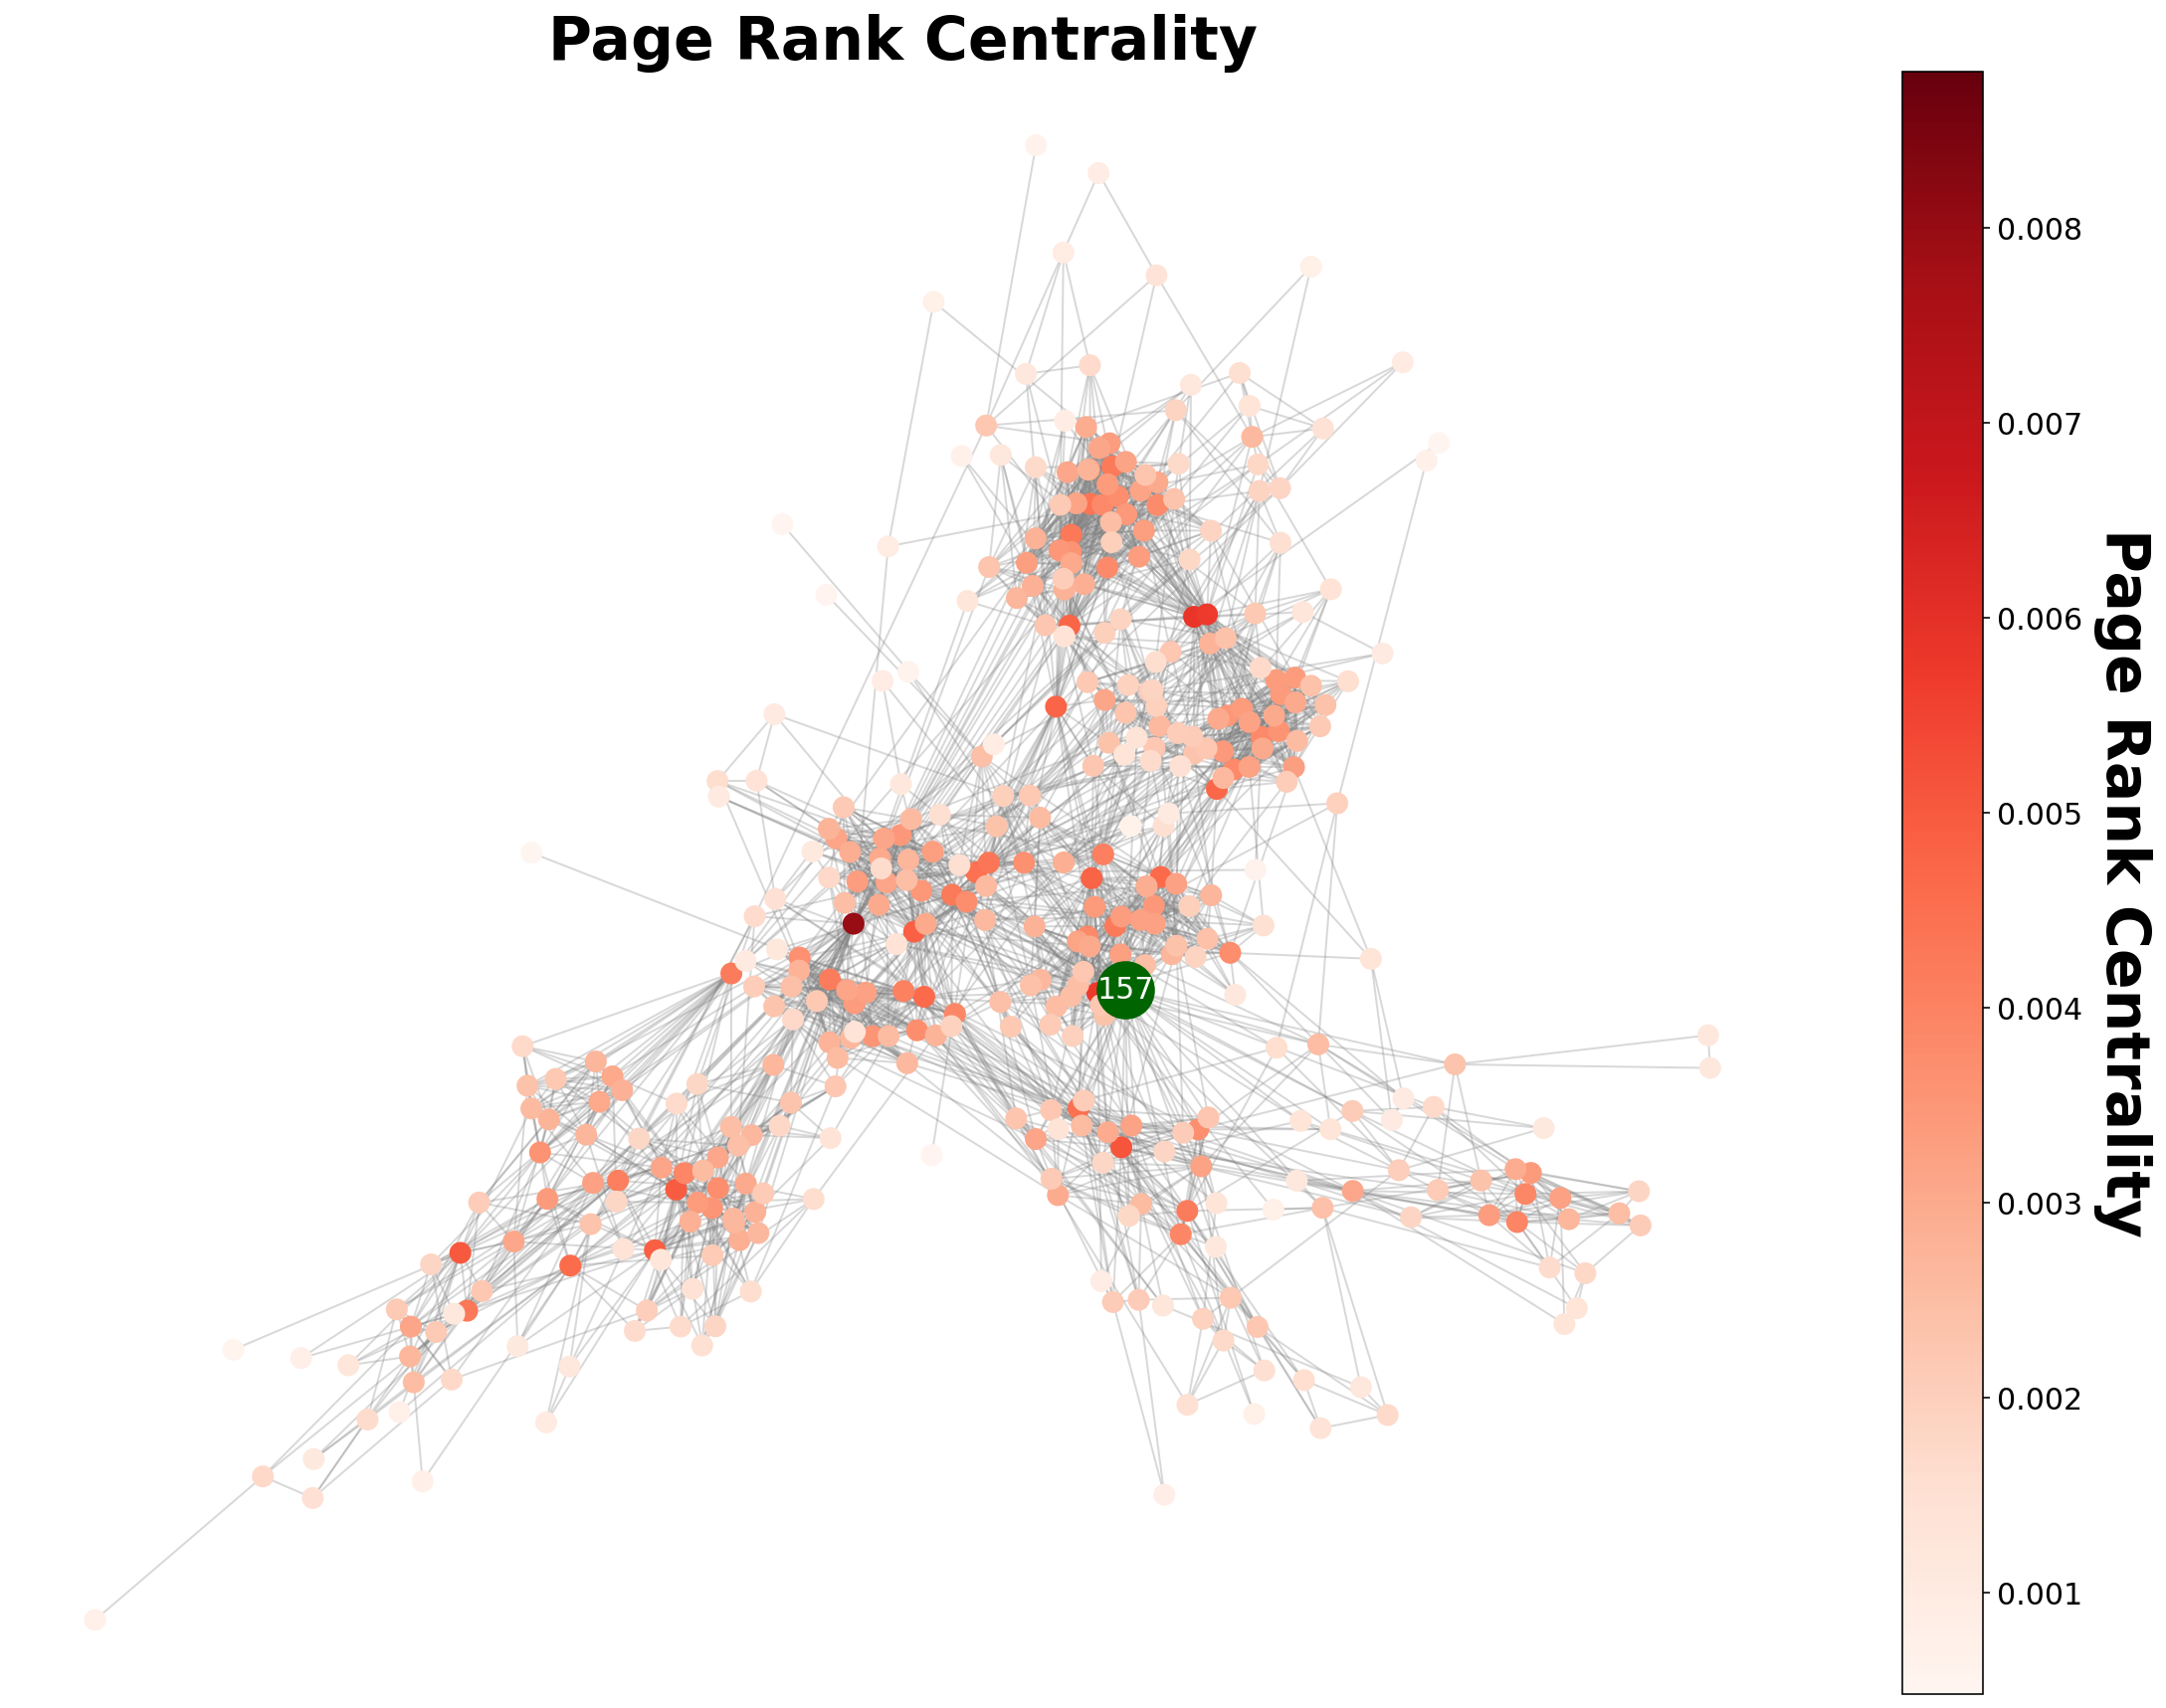

In [45]:
R = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
page_rank = nx.pagerank_scipy(R, alpha = 0.85)
page_rank_results = dict(sorted(page_rank.items(), key = lambda item: item[1], reverse = True))
pos = nx.spring_layout(R)
draw(R, pos, page_rank_results, 'Page Rank Centrality', plt.cm.Reds )

### (2.d) Influencer Ego network .
#### Define a function Draw_ego_network that inputs a network G (a networkx network), a network layout (as list of nodes position), and a node id and the maximum distance of interaction (as int). The function Draw_ego_network will output the network plot of G outlining (with a different color and bigger size) the node selected, and the ego network of the node id coloring in different color the links and the nodes depending on the interaction distance. Test your function with the network Gx, the node id of the influencer selected in the question 2.c, a network layout of your choice (that will improve the readability of the plot) and interaction distance 2.

In [49]:
def Draw_ego_network(G, pos, center_node, max_radius):
    """
    This function draws a network in a specified layout by considering a node as the center and all the other nodes 
    which are with in a maximum interaction distance by coloring them based on the distance from center.

    Parameters
    ----------
    G : graph
      A NetworkX graph

    pos : dictionary, 
      A dictionary with nodes as keys and positions as values.

    center_node : int
      The node which is to be considered as center

    max_radius: int
         Include all neighbors of distance<=radius from n.
    """
    
    # Get the Distance 
    dist_measure = nx.single_source_shortest_path_length(G, source = center_node, cutoff = max_radius) 
    ssp_distance_list = np.array(list(dist_measure.values()))
    node_sizes = ssp_distance_list.copy()
    clusters = list(set(ssp_distance_list)) # getting total no of clusters based on radius
    
    # Setting Node and Edge Colors based on distance from center
    ssp = nx.single_source_shortest_path(Gx, center_node, 3)
    edge_list = [[center_node, center_node]]
    edge_color = [0]
    node_color = []
    node_list = []
    for node, path in ssp.items():
        node_list.append(node)
        color = 1
        for i in range(len(path)-1):
            edge_list.append([path[i], path[i+1]]) # adding edge vertices
            edge_color.append(color) # adding edge color
            color+=1
        node_color.append(color-1) # adding node color
    
    # Setting node sizes based on distance
    max_size = 800    
    for i in range(max_radius+1):
        node_sizes[node_sizes == i] = max_size
        max_size = max_size/2.75

    plt.figure(figsize=(20, 10))
    plt.title('Influencer Ego network', size=30,weight='bold')
    pos = nx.spring_layout(G) # set layout
    color_map = mcolors.ListedColormap(plt.cm.Set3(clusters))
    
    # plot the graph
    nx.draw(Gx,pos, edge_color = 'gray', node_color='black', node_size=20, alpha=0.2)
    
    # Plot all the edges
    edges = nx.draw_networkx_edges(G, pos, edge_cmap = color_map,width = 1,\
                                   alpha=0.8, edgelist = edge_list, edge_color = edge_color)    
    # Plot all Reachable nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size = node_sizes, cmap = color_map, node_color = node_color, 
                                   nodelist = node_list, alpha = 0.8)
    # Plot Influencer node
    nx.draw_networkx_nodes(G, pos, node_size = 800, cmap = color_map, node_color = node_color[0], nodelist = [center_node])
    
    # Add label to Influencer Node 
    nx.draw_networkx_labels(G, pos, labels = {center_node : center_node}, font_size = 12)

    # Setting Color bar
    cb = plt.colorbar(nodes, ticks=range(0,len(clusters)), label='Degree')
    cb.set_label(label='Degree',size=30,weight='bold')
    cb.ax.tick_params(labelsize= 30)
    cb.set_ticklabels(list(set(dist_measure.values())))
    nodes.set_clim(-0.5, len(clusters)-0.5)
    plt.axis('off')
    plt.show()

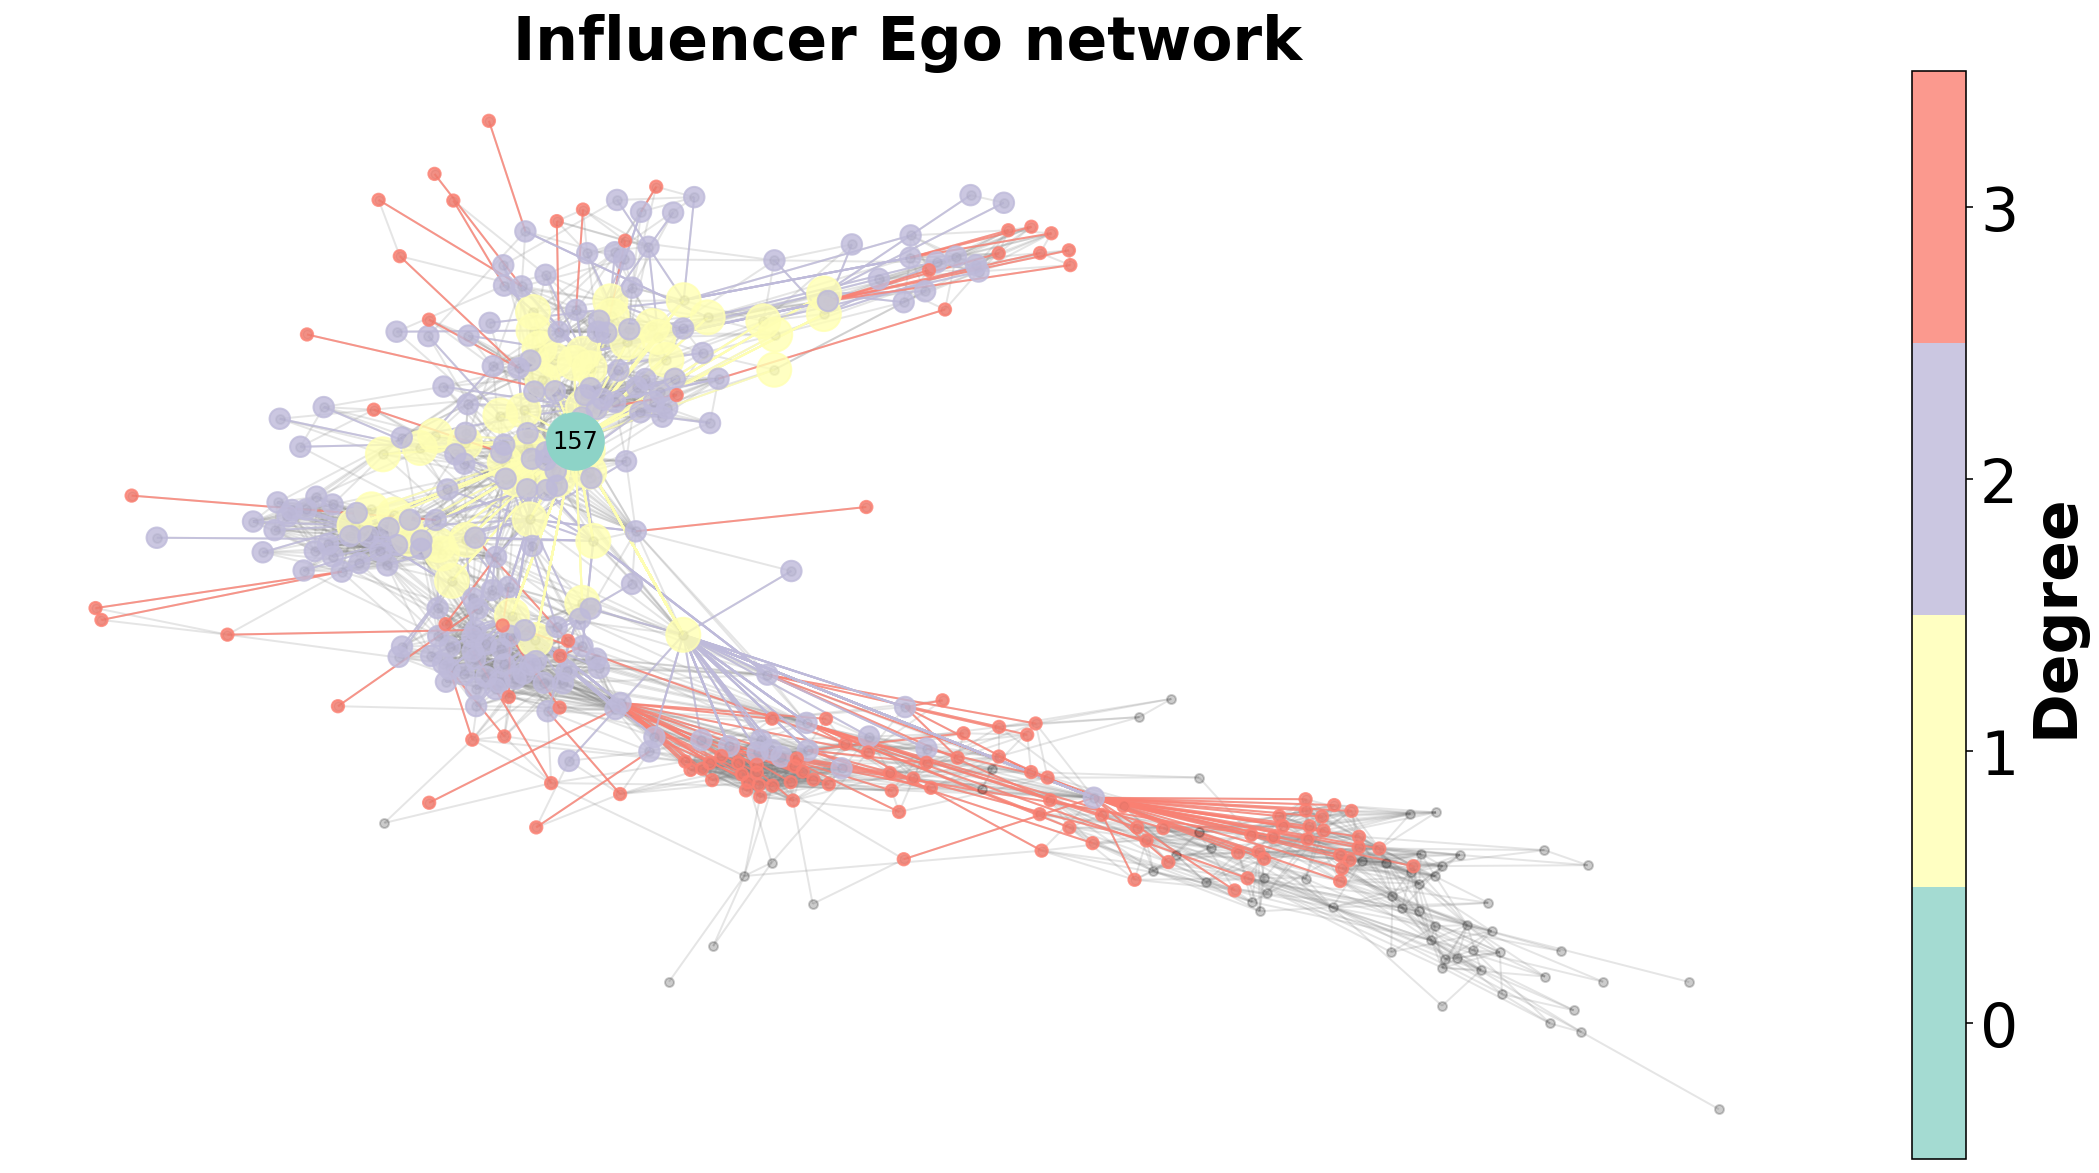

In [50]:
central_node = 157
max_radius = 3
pos = nx.spring_layout(Gx)
Draw_ego_network(Gx, pos, central_node, max_radius)

### (2.e) Community Detection. 
#### Decide and declare a community algorithm of your choice among the ones we saw during the lectures ECMM466. Imagine that G is now representing a topological map of distances between the nodes. A link between any pair of nodes means that you can travel between the pair of nodes in a hour. If a link is not present you can not travel between the nodes. You are been hired by a delivery agency to select the perfect location for its new two garages. The delivery agency wants to start its business serving the two biggest community of the network Gx based on the algorithm you decided. Where are you suggesting to build the two garages (node id)? Which metric are you using to motivate you answer? Why? Plot the sub-network of the two selected communities, with the metric you selected, outlining with different color and size the nodes you proposed as garages’ locations. (As possible output of the plot see the labs.)

For the purposes of this question, we will use Louvain algorithm which works by maximizing modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities.

In [19]:
def get_communities_sorted(G):
    """
    This function returns a dictionary with keys as communities and values as the nodes that belong to the community

    Parameters
    ----------
    G : graph
      A NetworkX graph
    
    Returns
    ----------
    final_comm_dict : dict
       Dictionary with communities in sorted order based on community size
    """
    # Getting the best partition
    best_partition = community_louvain.best_partition(G)
    
    #sorting the partitions based on node count
    comm_count = collections.Counter(best_partition.values())
    communities_in_order = [community_index for community_index, count in comm_count.most_common()]
    # Get the community indices sorted by size as a dictionary old_index : new_index
    new_com_ind = {}
    for i in range(len(communities_in_order)):
        new_com_ind[communities_in_order[i]] = i

    # arranging the dictionary such that the community from 0 to n(keys) are the largest to smallest communities
    sorted_partition = best_partition.copy()
    for key, value in best_partition.items():
        sorted_partition[key] = new_com_ind[value]
    # appending all the nodes that belong to a community as a list to each community
    final_comm_dict = defaultdict(list)
    for i, j in sorted_partition.items():
        final_comm_dict[j].append(i)
        
    return final_comm_dict

In [20]:
# G = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
final_comm_dict = get_communities_sorted(Gx) 
c1 = final_comm_dict[0]
c2 = final_comm_dict[1]

In [21]:
print("Based on Louvain algorithm, we've calculated the 2 biggest communities. They're as follows:\n")
print(f"Nodes of Community 1: {c1}\n")
print(f"Nodes of Community 2: {c2}\n")

Based on Louvain algorithm, we've calculated the 2 biggest communities. They're as follows:

Nodes of Community 1: [76, 4, 159, 252, 290, 302, 381, 393, 304, 32, 15, 72, 118, 134, 31, 16, 99, 151, 165, 176, 204, 218, 232, 242, 244, 336, 356, 359, 56, 17, 133, 152, 279, 330, 399, 40, 18, 212, 256, 384, 26, 82, 166, 383, 390, 33, 253, 310, 68, 80, 137, 138, 230, 254, 289, 325, 346, 394, 395, 406, 46, 113, 187, 344, 374, 89, 106, 117, 367, 375, 108, 332, 352, 107, 198, 260, 379, 123, 202, 329, 248, 345, 368, 199, 164, 268]

Nodes of Community 2: [14, 157, 6, 3, 28, 57, 96, 109, 110, 128, 129, 172, 197, 236, 241, 245, 249, 287, 307, 398, 22, 188, 214, 265, 363, 179, 62, 10, 92, 385, 139, 262, 301, 319, 401, 146, 19, 257, 87, 100, 250, 35, 25, 79, 124, 156, 276, 298, 378, 86, 312, 50, 55, 334, 387, 389, 42, 190, 264, 373, 119, 48, 209, 211, 65, 224, 295, 350, 215, 77, 103, 294, 317, 382, 391, 403, 340, 299, 280, 309, 167, 409, 171, 203, 247]



<b>Now, to get the perfect location for the Garage in each of the communities,</b>
-  I believe that the garage should be as close as possible to all the nodes i.e., it should have the shortest traversal path length to all the nodes.
- <b>Closeness Centrality</b> is the metric that provides us with this feature. 
As it is reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph, the higher the closeness centrality value of a node is, the closer it is to all other nodes.

In [22]:
def get_location_node(G, nodes, measure):
    """
    This function returns the node which is the best location, based on the centrality measure 

    Parameters
    ----------
    G : graph
      A NetworkX graph

    nodes : list
      The list of node that belong to a community

    measure: function
         the centrality measure function

    Returns
    ----------
    location: int
        the best location
    """
    
    community = G.subgraph(nodes)
    cc = measure(community)
    location = max(cc.items(), key=operator.itemgetter(1))[0]
    return location

#### Let us draw the entire graph with the the 2 communities in different colors and proposed locations in bigger size 


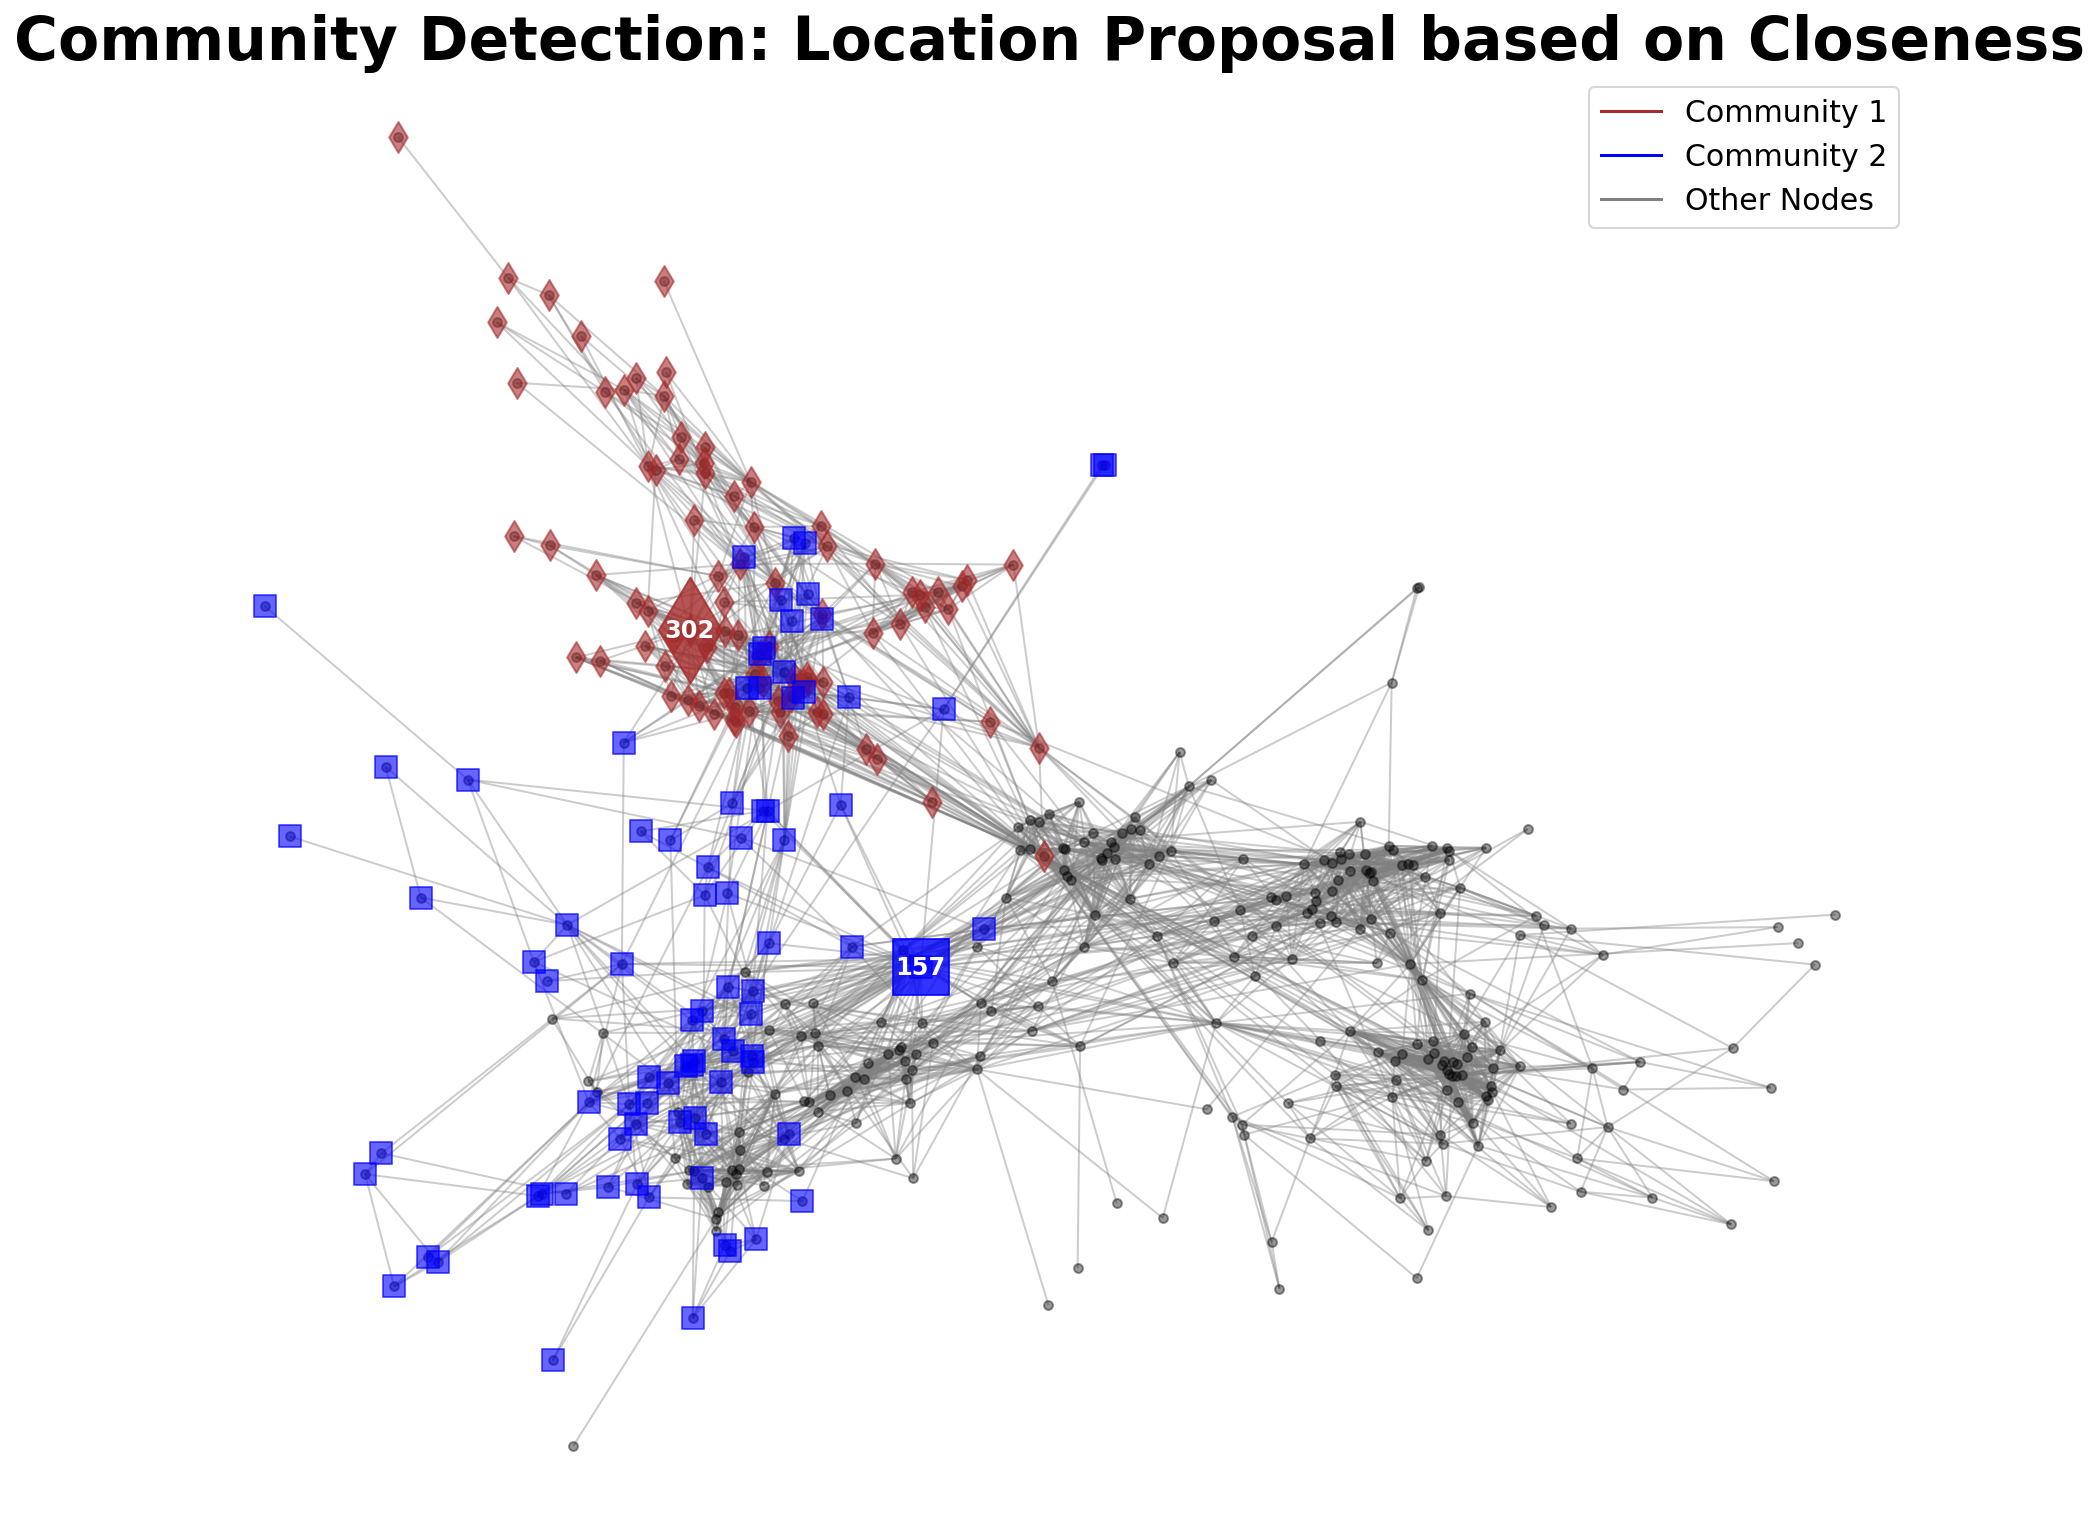

In [23]:
# Setting the Layout
pos = nx.spring_layout(Gx, k = 0.005)
plt.figure(figsize=(12, 10))

# Getting the locations of central nodes
c1_location = get_location_node(Gx, final_comm_dict[0], nx.closeness_centrality)
c2_location = get_location_node(Gx, final_comm_dict[1], nx.closeness_centrality)

# Plotting the Graph
nx.draw(Gx, pos, edge_color = 'gray', node_color='black', node_size=20, alpha=0.4)
# Plotting the Location of Garage in Community 1
nx.draw_networkx_nodes(Gx, pos, node_size = 1400, node_color = 'brown', 
                               nodelist = [c1_location], alpha = 0.8, node_shape = 'd')
# Plotting the Location of Garage in Community 2
nx.draw_networkx_nodes(Gx, pos, node_size = 800, node_color = 'blue', 
                               nodelist = [c2_location], alpha = 0.8, node_shape = 's')
# Plotting the both the Communities in different shape and color
nx.draw_networkx_nodes(Gx, pos, node_size = 120,  node_color = 'brown', nodelist = c1, alpha = 0.6, node_shape = 'd')
nx.draw_networkx_nodes(Gx, pos, node_size = 120,  node_color = 'blue', nodelist = c2, alpha = 0.6, node_shape = 's')
nx.draw_networkx_labels(Gx, pos, {c1_location : c1_location, c2_location:c2_location}, font_color = 'w', font_weight = 'bold')
# Adding Legend
plt.plot([],[], label= 'Community 1',  color = 'brown')
plt.plot([],[], label= 'Community 2',  color = 'blue')
plt.plot([],[], label= 'Other Nodes',  color = 'gray')
plt.title('Community Detection: Location Proposal based on Closeness', size=30,weight='bold')
plt.legend( loc = 'best', prop={'size': 15})
plt.show()

Based on the above, the nodes proposed are 157 in community 2 and 302 in community 1.

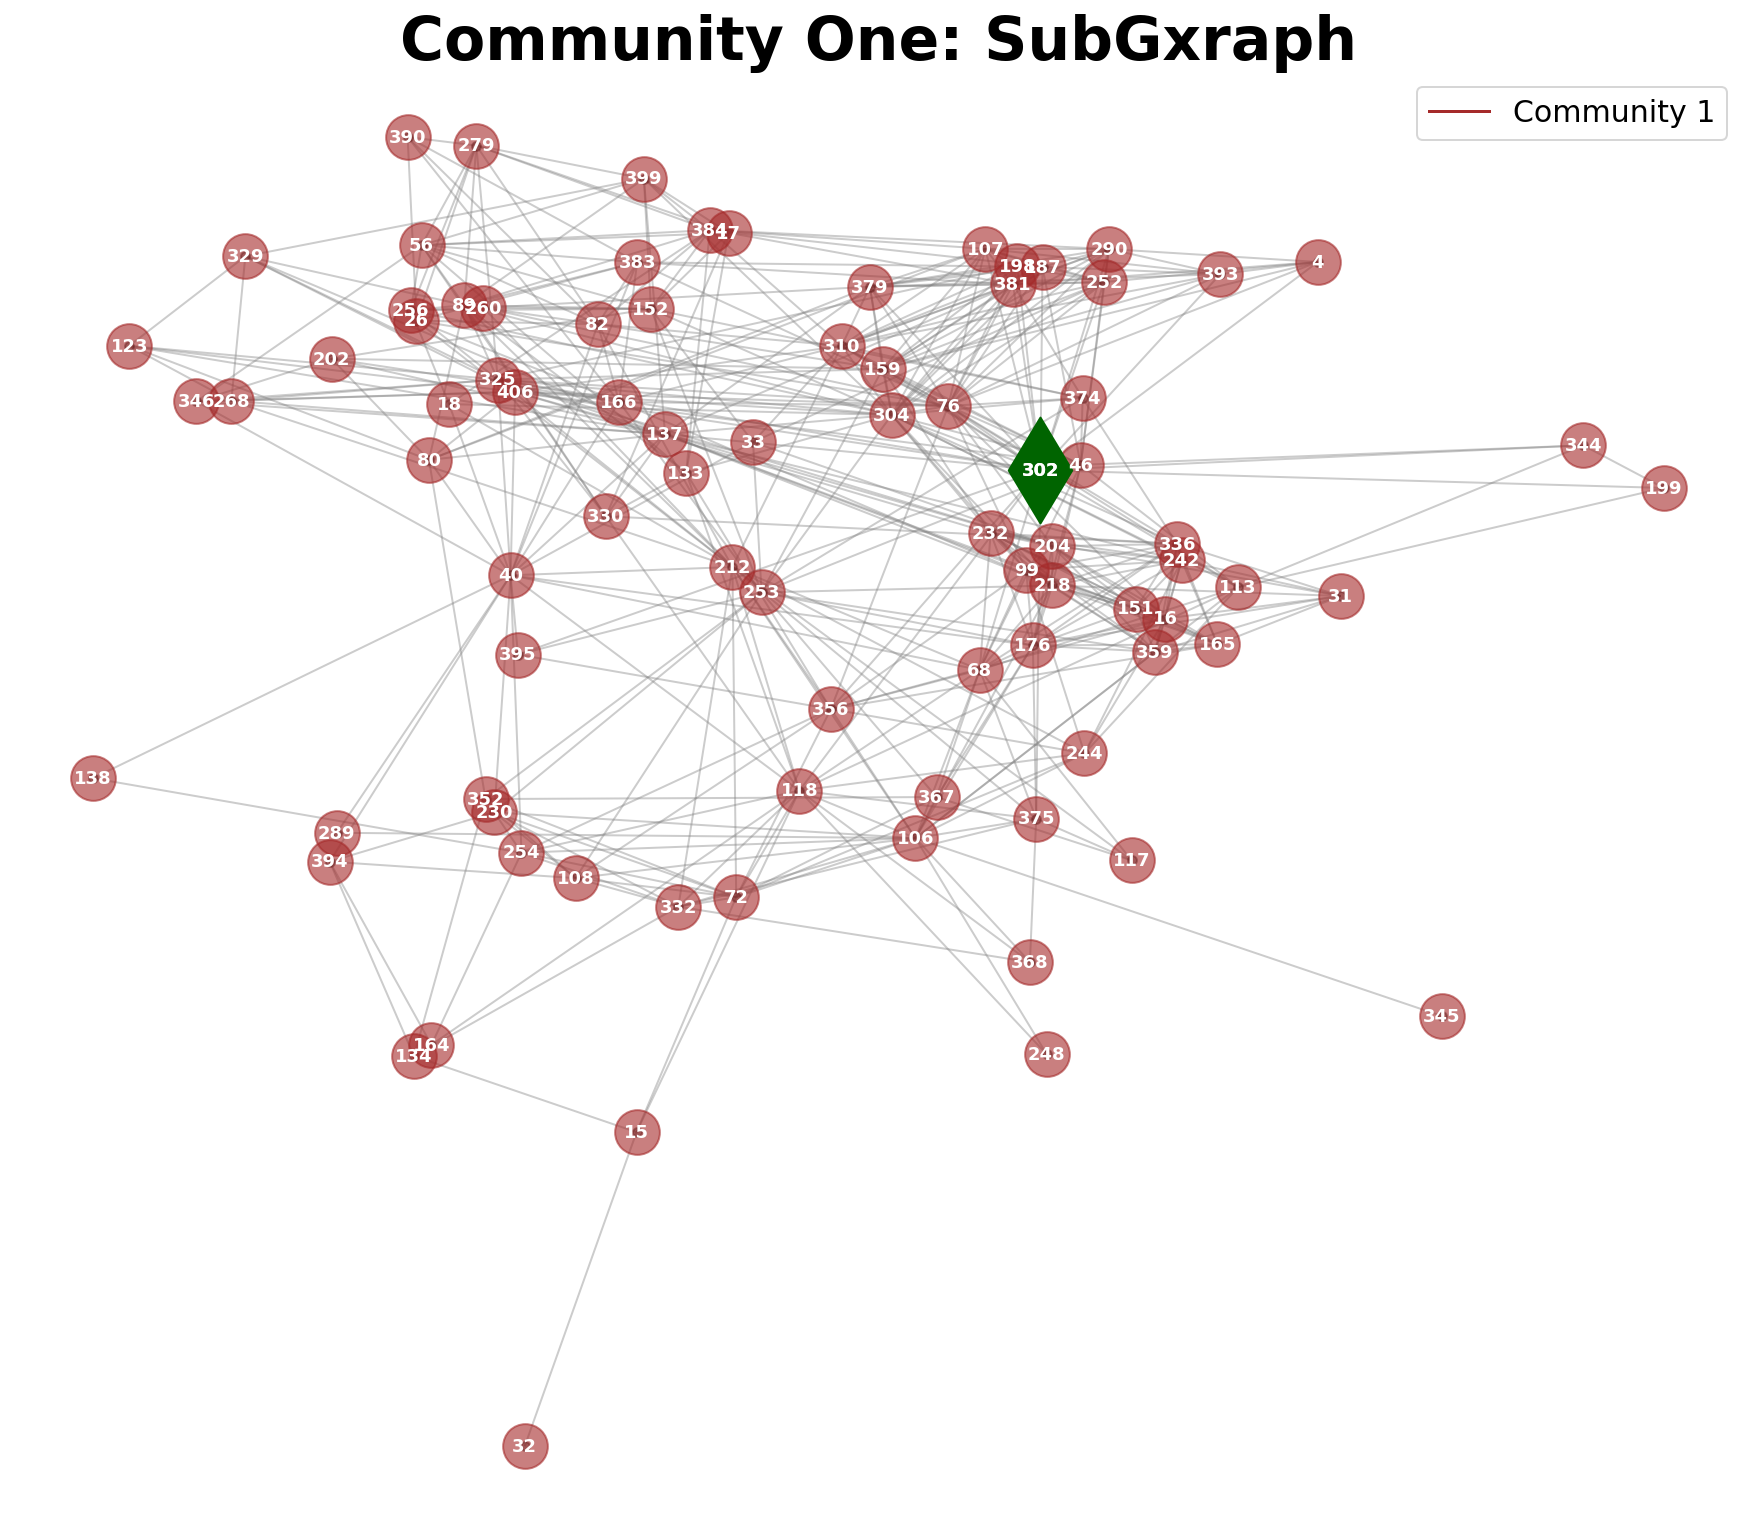

In [24]:
# Let us draw the entire graph with the the 2 communities in different colors and proposed locations in bigger size 
Gx = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
plt.figure(figsize=(12, 10))
# Setting Gx_C1 as subgraph based on list of nodes belongong to community 1
Gx_C1 = Gx.subgraph(c1)
pos = nx.spring_layout(Gx_C1, k = 0.01)
# Plotting the Gxraph
nx.draw(Gx_C1, pos, edge_color = 'gray', node_color='black', node_size=20, alpha=0.4, nodelist = c1)

# Plotting the Location of Gxarage in Community 1
nx.draw_networkx_nodes(Gx_C1, pos, node_size = 500,  node_color = 'brown', nodelist = c1, alpha = 0.6, node_shape = 'o')
nx.draw_networkx_nodes(Gx_C1, pos, node_size = 1400, node_color = 'darkgreen', 
                               nodelist = [c1_location], alpha = 1, node_shape = 'd')
# Plot the labels
nx.draw_networkx_labels(Gx_C1, pos, font_color = 'w', font_weight = 'bold', font_size= 9)
nx.draw_networkx_labels(Gx_C1, pos, {c1_location : c1_location}, font_color = 'w', font_weight = 'bold', font_size = 9)
plt.plot([],[], label= 'Community 1',  color = 'brown')
plt.title('Community One: SubGxraph', size=30,weight='bold')
plt.legend( loc = 'best', prop={'size': 15})
plt.show()

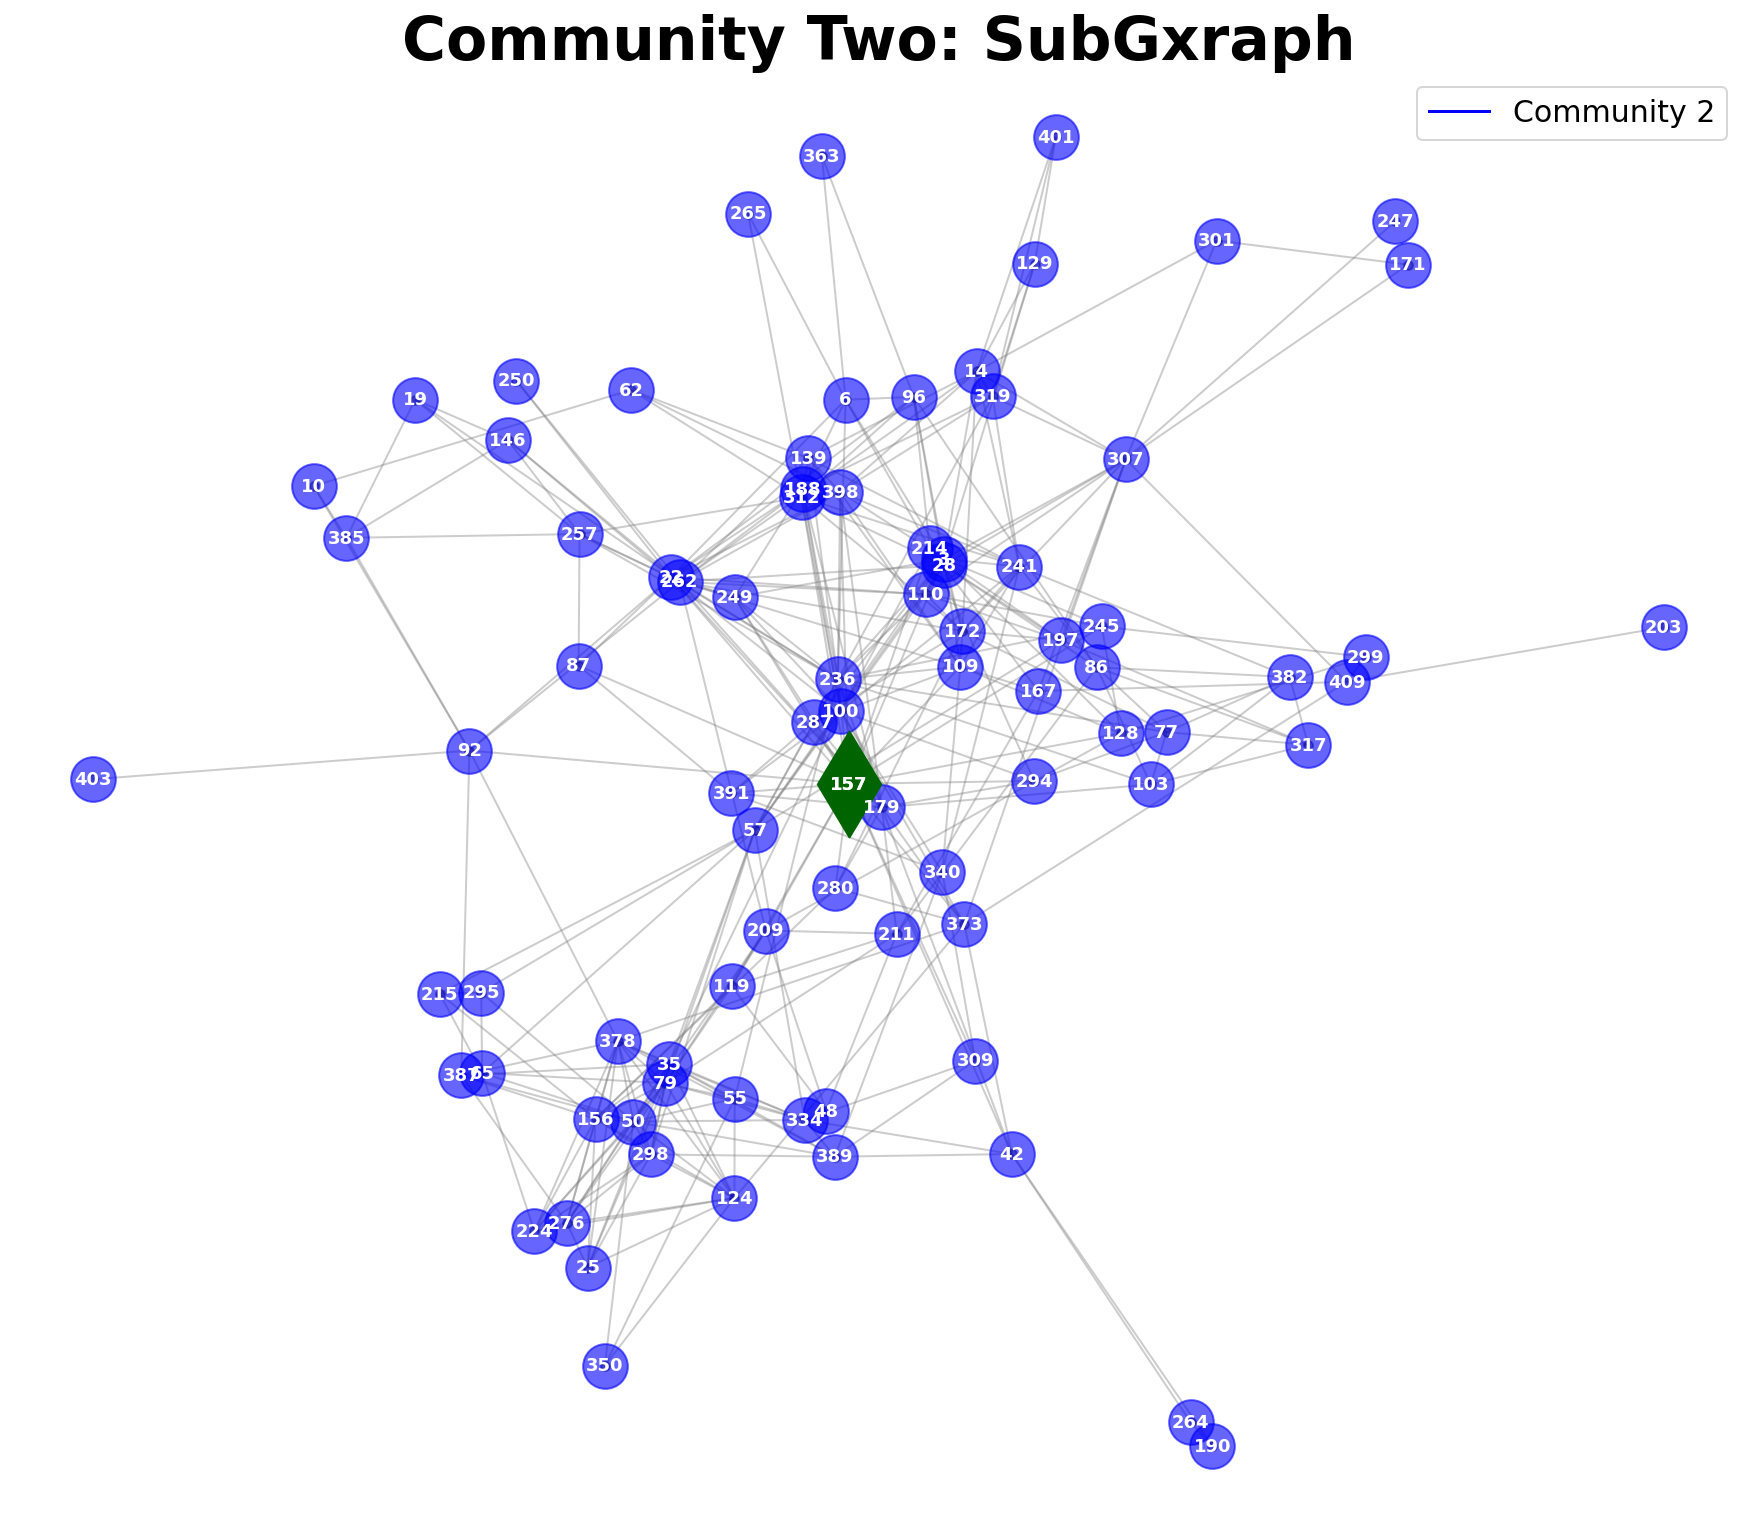

In [25]:
# Let us draw the entire graph with the the 2 communities in different colors and proposed locations in bigger size 
Gx = nx.read_edgelist('infect-dublin.edges', nodetype=int, edgetype=int)
plt.figure(figsize=(12, 10))
# Setting Gx_C2 as subgraph based on list of nodes belongong to community 1
Gx_C2 = Gx.subgraph(c2)
pos = nx.spring_layout(Gx_C2, k = 0.01)
# Plotting the Gxraph
nx.draw(Gx_C2, pos, edge_color = 'gray', node_color='black', node_size=20, alpha=0.4, nodelist = c2)

# Plotting the Location of Gxarage in Community 1
nx.draw_networkx_nodes(Gx_C2, pos, node_size = 500,  node_color = 'blue', nodelist = c2, alpha = 0.6, node_shape = 'o')
nx.draw_networkx_nodes(Gx_C2, pos, node_size = 1400, node_color = 'darkgreen', 
                               nodelist = [c2_location], alpha = 1, node_shape = 'd')
# Plot the labels
nx.draw_networkx_labels(Gx_C2, pos, font_color = 'w', font_weight = 'bold', font_size= 9)
nx.draw_networkx_labels(Gx_C2, pos, {c2_location : c2_location}, font_color = 'w', font_weight = 'bold', font_size = 9)
plt.plot([],[], label= 'Community 2',  color = 'blue')
plt.title('Community Two: SubGxraph', size=30,weight='bold')
plt.legend( loc = 'best', prop={'size': 15})
plt.show()

# (2.f) Adjacency matrix of the Community Detection


In [26]:
def plot_adj_comm(G, measure, ):
    best_partition = measure.best_partition(G)
    comm_count = collections.Counter(best_partition.values())
    communities_in_order = [community_index for community_index, count in comm_count.most_common()[-1:]]
    new_com_ind = {}
    for i in range(len(communities_in_order)):
        new_com_ind[communities_in_order[i]] = i
    sorted_counts = dict(sorted(comm_count.items(),key=lambda item: item[1], reverse = True))
    sorted_partition = {k: v for k, v in sorted(best_partition.items(), key=lambda item: item[1], reverse = True)}

    final_comm_dict = defaultdict(list)
    for i, j in sorted_partition.items():
        final_comm_dict[j].append(i)
    nodes_list = [nodes for community in final_comm_dict.values() for nodes in community]
    adjacency_matrix = nx.to_numpy_matrix(G, nodelist = nodes_list)
    return adjacency_matrix

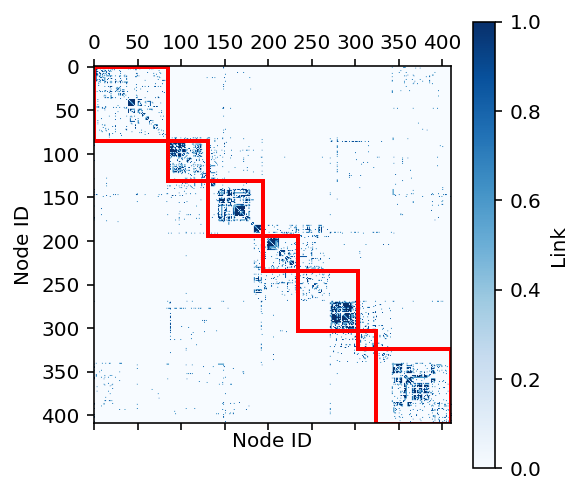

In [27]:
adjacency_matrix = plot_adj_comm(Gx, community_louvain)

plt.matshow(adjacency_matrix,interpolation=None, cmap = plt.cm.Blues)
plt.colorbar(label='Link')
plt.xlabel('Node ID')
plt.ylabel('Node ID')

split = [final_comm_dict.values()]
colours = ['r']

ax = plt.gca()

# Plot the red boxes based on partitions
for split, color in zip(split, colours):
    idx = 0 
    for m in split:
        ax.add_patch(patches.Rectangle((idx, idx),len(m),len(m),facecolor="none", edgecolor = color,linewidth="2"))
        idx += len(m)
plt.show()